In [1]:
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import convnext_base, convnext_small

from eg3d_dataset import EG3DDataset
from eg3d import EG3D

In [2]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 512  # the generated image resolution
    
    eg3d_model_path = 'eg3d/eg3d_model/ffhqrebalanced512-128.pkl'
    data_dir = 'data_color/'
    df_file = 'dataset.df'

config = TrainingConfig()

In [3]:
preprocess = transforms.Compose(
        [
            transforms.Resize(config.image_size),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

dataset = EG3DDataset(df_file=config.df_file, data_dir=config.data_dir, transform=preprocess, encode=False)

In [4]:
model = convnext_small(num_classes=512)
loss_function = nn.L1Loss()

In [5]:
model.load_state_dict(torch.load('eg3d-latent-interpreter/model.pth')['model_state_dict'])
eg3d = EG3D('eg3d/eg3d_model/ffhqrebalanced512-128.pkl')

tensor([-0.1747, -0.7116, -0.0256,  1.3835,  0.2297, -0.0606,  1.6689, -0.0821,
        -0.9719, -0.8044])
tensor([ 1.2197, -0.5335,  1.1350,  0.3606, -0.8466, -0.0942, -0.4570, -0.2290,
         0.5966,  0.0798], grad_fn=<SliceBackward0>)
Targets STD: 1.0059322118759155
LV STD: 0.5200054049491882
Loss: 0.8585572242736816


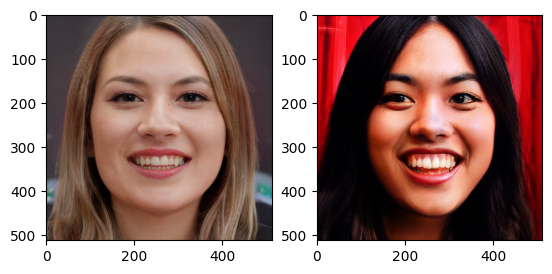

In [13]:
import matplotlib.pyplot as plt

transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

batch = dataset[np.random.randint(low=0, high=len(dataset))]
imgs, targets = batch['images'].unsqueeze(0), batch['latent_vectors'].unsqueeze(0)

latent_vectors = model(transform(imgs))[0]

print(targets[0][:10])
print(latent_vectors[:10])
print(f"Targets STD: {np.std(targets.detach().cpu().numpy())}")
print(f"LV STD: {np.std(latent_vectors.detach().cpu().numpy())}")

print(f"Loss: {loss_function(latent_vectors, targets)}")

img = eg3d.generate_imgs(latent_vectors.unsqueeze(0))[0].cpu().numpy()
img = img.transpose(1, 2, 0)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(imgs[0].cpu().numpy().transpose(1, 2, 0))
axarr[1].imshow(img)
plt.show()

In [7]:
print(targets.amax())
print(latent_vectors.amax())

tensor(2.4523)
tensor(1.2328, grad_fn=<AmaxBackward0>)
